<a href="https://colab.research.google.com/github/Mitmischer/sepsis-prediction/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sepsis Prediction
Early prediction of sepsis from clinical data, using the [PhysioNet/Computing in Cardiology Challenge 2019 Dataset](https://physionet.org/content/challenge-2019/1.0.0/)

## Setup

In [51]:
from google.colab import drive
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%pip install zstandard
import zstandard
drive.mount('/content/drive')
%mkdir -p "/tmp/sepsis"
%cp "/content/drive/My Drive/sepsis/training.tar.zst" "/tmp/sepsis"
%cd "/tmp/sepsis"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 17.2 MB/s eta 0:00:00
Mounted at /content/drive
/tmp/sepsis


In [3]:
%cp "/content/drive/My Drive/sepsis/training_setA.csv" "/tmp/sepsis"

**Read data file**

In [4]:
full_df = pd.read_csv("/tmp/sepsis/training_setA.csv")

In [5]:
dctx = zstandard.ZstdDecompressor()
with open("training.tar.zst", 'rb') as ifh, open("training.tar", 'wb') as ofh:
    dctx.copy_stream(ifh, ofh)

my_tar = tarfile.open('training.tar')
my_tar.extractall('/tmp/sepsis') # specify which folder to extract to
my_tar.close()
%cd "training/training_setA"

/tmp/sepsis/training/training_setA


In [6]:
# load all data sets (roughly 20000 for set A)
wd = Path(".")
full_df_from_disk = list(pd.read_csv(f, sep = "|") for f in wd.glob("p0*.psv"))
#full_df = pd.concat(full_df_from_disk)

## Preprocess Data File
Only if data was read in via .psv files

In [ ]:
full_df.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,NaN,134.0,72.67,NaN,20.0,NaN,NaN,...,NaN,266.0,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,NaN,NaN,NaN,143.0,80.33,NaN,NaN,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.22,154.0,83.33,NaN,16.0,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,NaN,155.0,98.33,NaN,20.0,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,5,0,0


In [ ]:
full_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

Reset index, creating time variable

In [ ]:
full_df = full_df.reset_index(names=["time"])

Add patient id variable

In [ ]:
groups = full_df['time'].diff().lt(0).cumsum()

In [ ]:
full_df['patient_id'] = groups

Optional: save as csv

In [ ]:
# full_df.to_csv("/tmp/sepsis/training_setA.csv", index=False)

## Exploratory Data Analysis

### Single and Subsample Analysis

Single case

In [7]:
first_patient_df = pd.read_csv("p000010.psv", sep="|")

<Axes: >

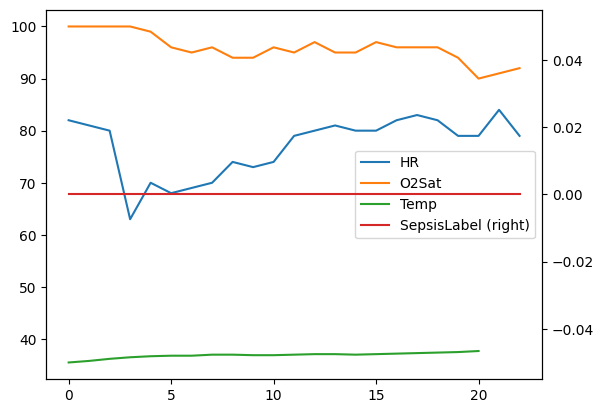

In [8]:
ax = first_patient_df[["HR", "O2Sat", "Temp"]].plot()
first_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

In [10]:
first_patient_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

<Axes: >

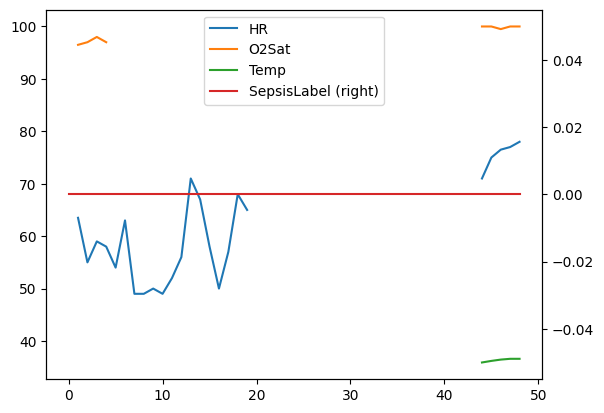

In [37]:
second_patient_df = pd.read_csv("p000111.psv", sep="|")
ax = second_patient_df[["HR", "O2Sat", "Temp"]].plot()
second_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

Subsample (first n samples)

In [38]:
# load the first 10 data sets
wd = Path(".")
sample_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p00000*.psv"))
sample_df = pd.concat(sample_df)

<Axes: >

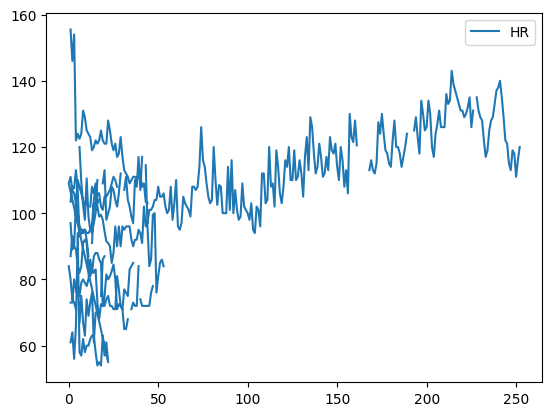

In [39]:
sample_df[["HR"]].plot()

39.6956956956957 mean total hours time in the ICU


Text(0.5, 0, 'ICULOS (days)')

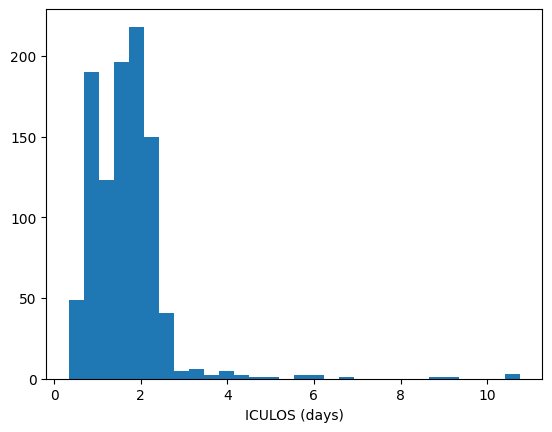

In [40]:
# load the first 1000 data sets
# what is the mean total time in the ICU (ICULOS)?
# ICULOS = intensive care unit length of stay
wd = Path(".")
big_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p000*.psv"))
ICULOS_times = np.array([])
for df in big_df:
  ICULOS_times = np.append(ICULOS_times, df[["ICULOS"]].max())
print(f"{np.mean(ICULOS_times)} mean total hours time in the ICU")
plt.hist(ICULOS_times/24, bins=30)
plt.xlabel('ICULOS (days)')

### Full Sample Analysis

Number of patiens in total and patients with sepsis

In [47]:
print("Number of patients:", len(full_df['patient_id'].unique()))

grp_sepsis_rep = np.array(full_df.groupby(['patient_id']) \
                          ['SepsisLabel'].sum())

print("Number of patients with sepsis:", len(grp_sepsis_rep[grp_sepsis_rep > 0]))


print("Percentage of positive cases:", round(len(grp_sepsis_rep[grp_sepsis_rep > 0])/len(full_df['patient_id'].unique())*100, 2), "%")
     


Number of patients: 20336
Number of patients with sepsis: 1790
Percentage of positive cases: 8.8 %


Number of hours a patient spent in hospital

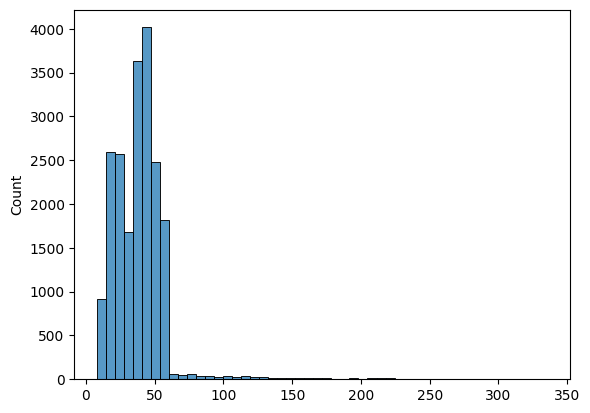

In [42]:
agg_patient_time = np.array(full_df.groupby(['patient_id'])['SepsisLabel']\
                            .count())

sns.histplot(agg_patient_time, kde=False, bins = 50);

Time at which a patient contracts Sepsis

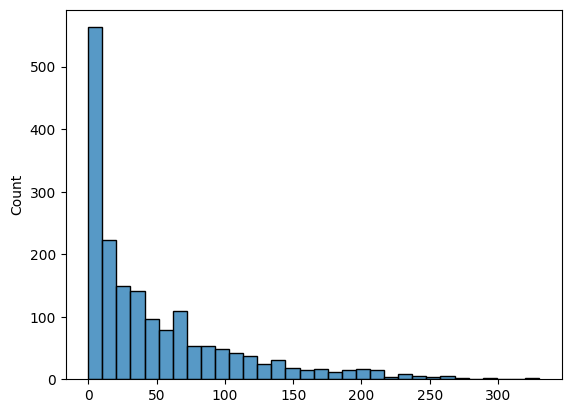

In [48]:

temp = full_df.groupby(['patient_id'])['SepsisLabel']\
       .sum().reset_index()

sepsis_pid = np.array(temp[temp['SepsisLabel'] > 0]['patient_id'])


temp_filter = full_df[full_df['patient_id']\
                                   .isin(sepsis_pid)]

sepsis_time = []
tot_time = []


for pid in sepsis_pid:
  df = temp_filter[temp_filter['patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])
  
sns.histplot(sepsis_time, kde=False);


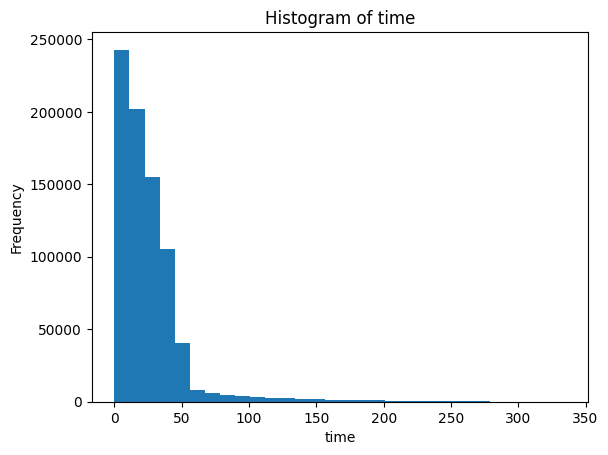

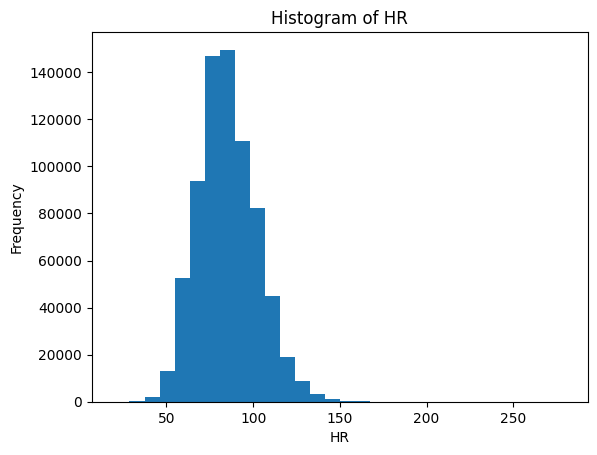

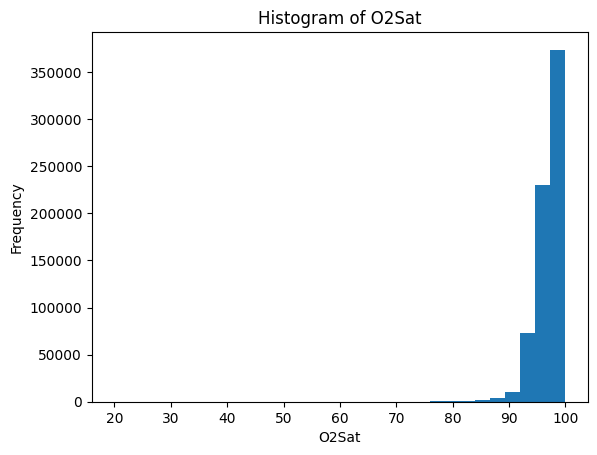

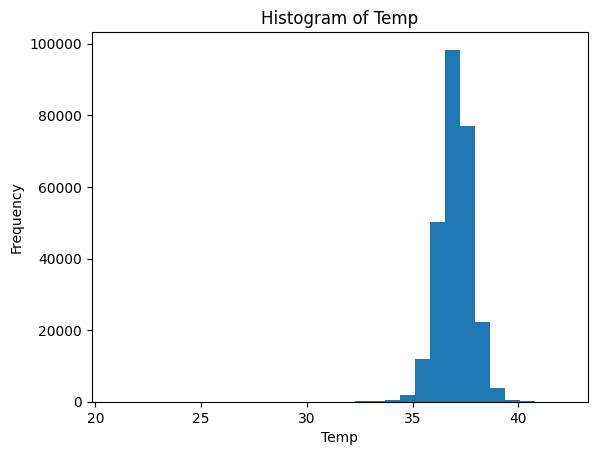

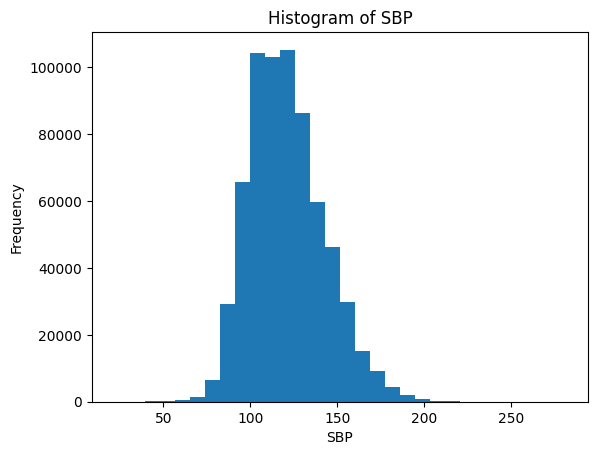

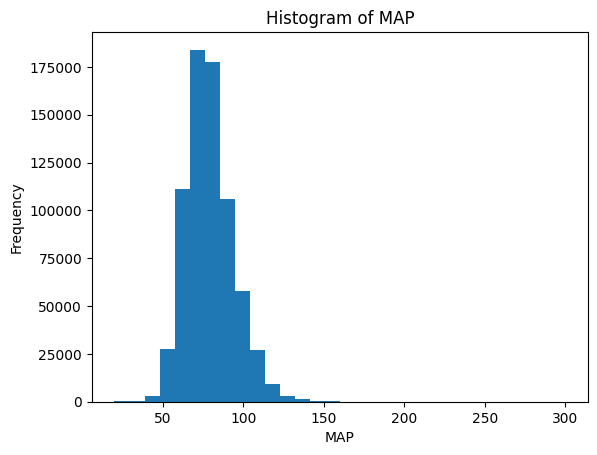

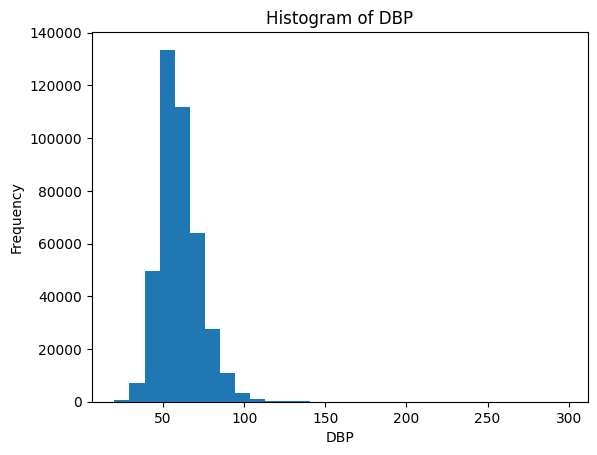

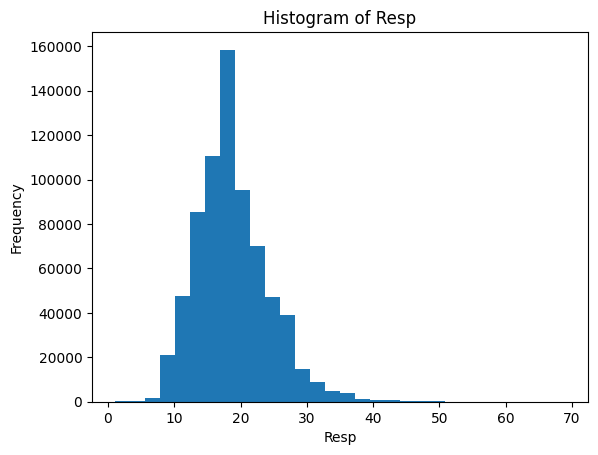

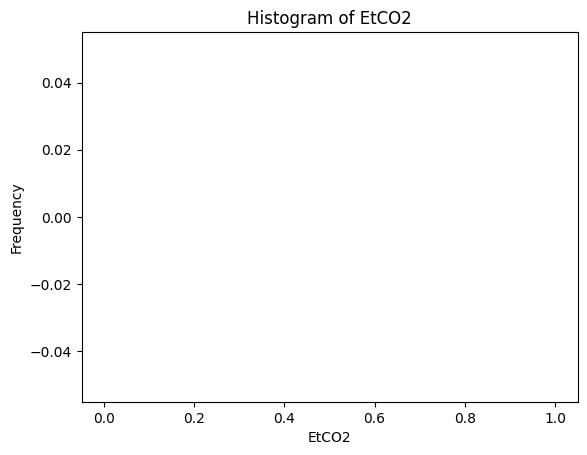

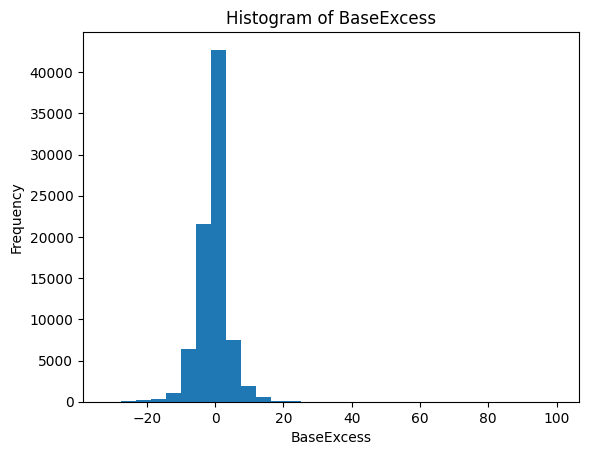

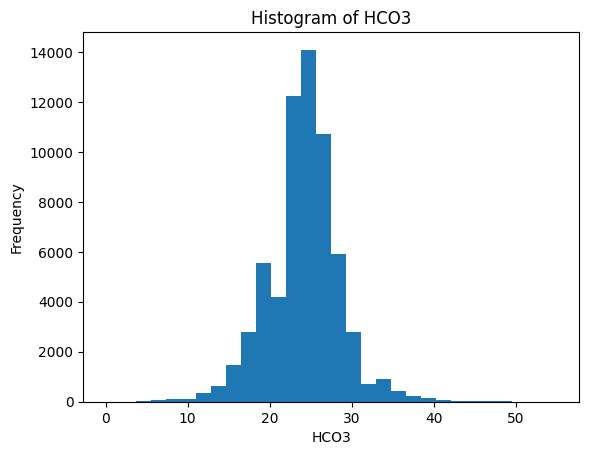

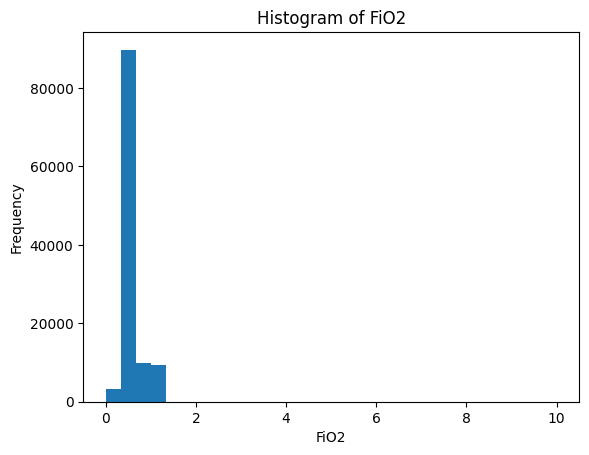

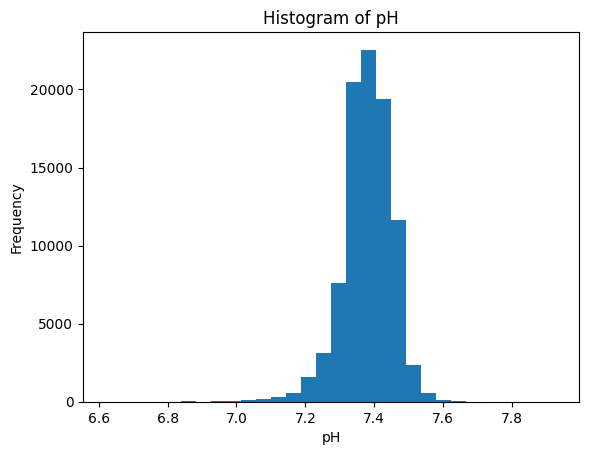

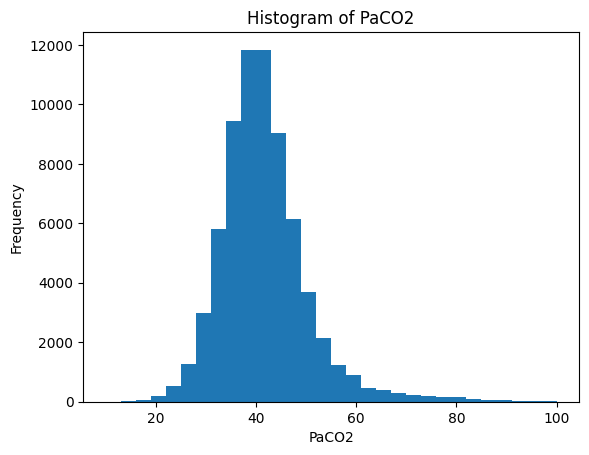

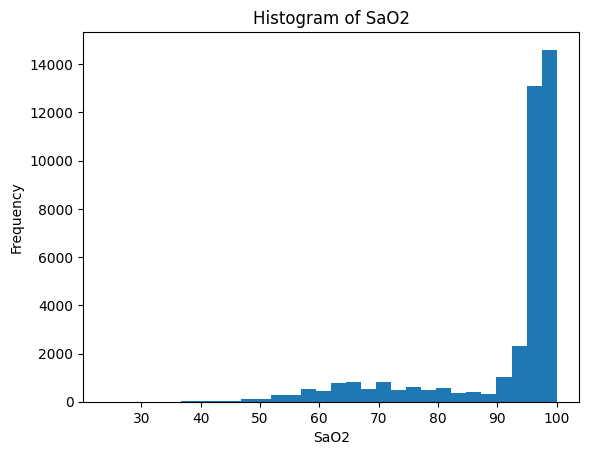

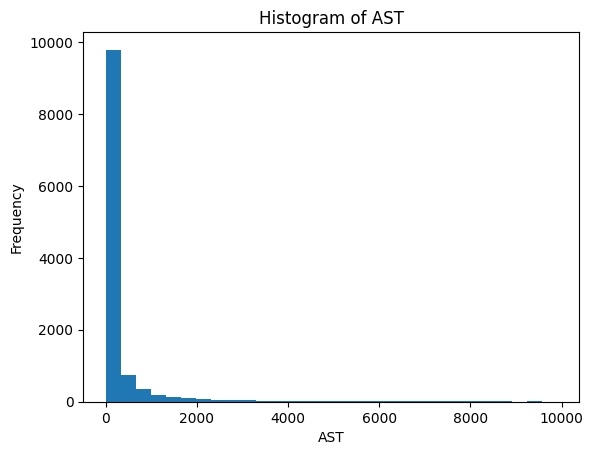

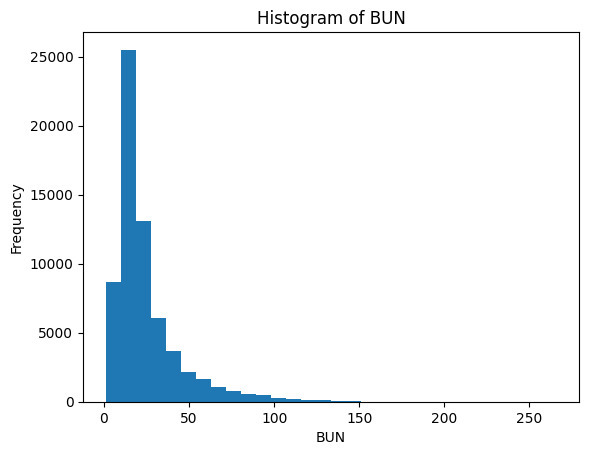

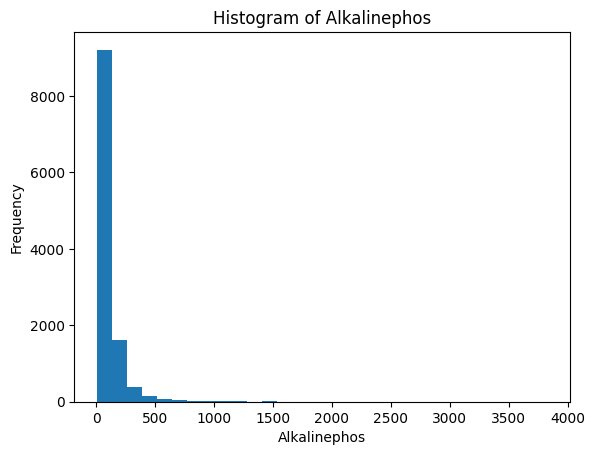

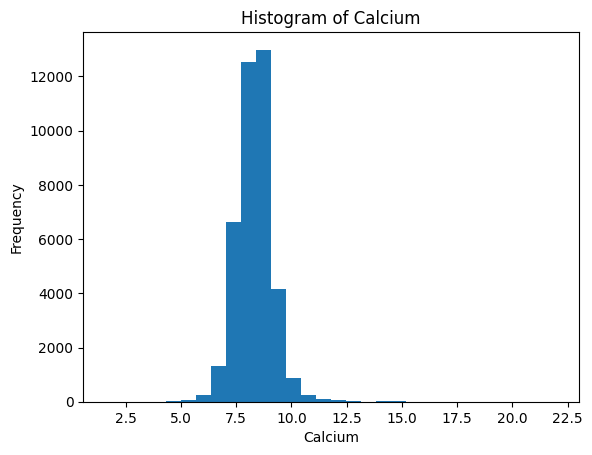

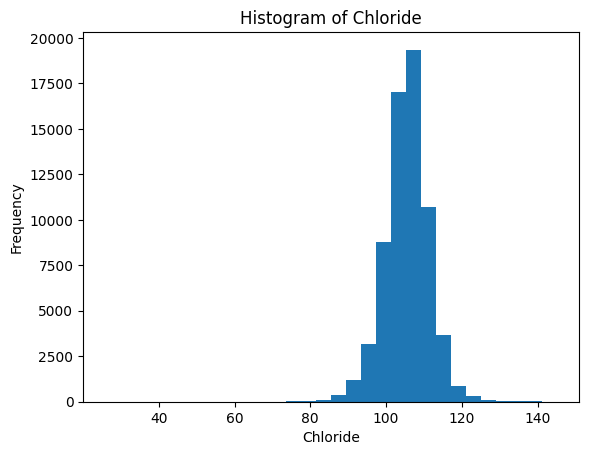

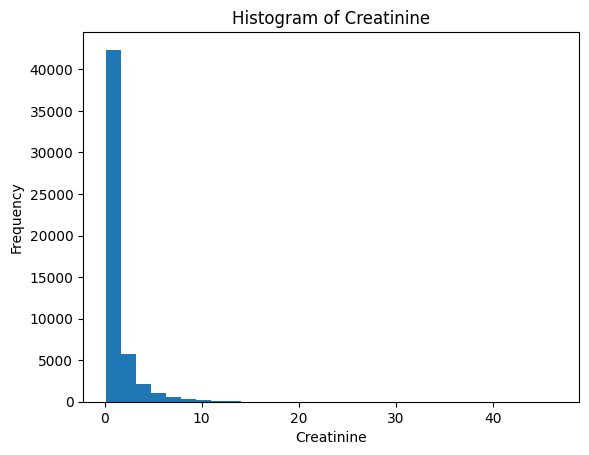

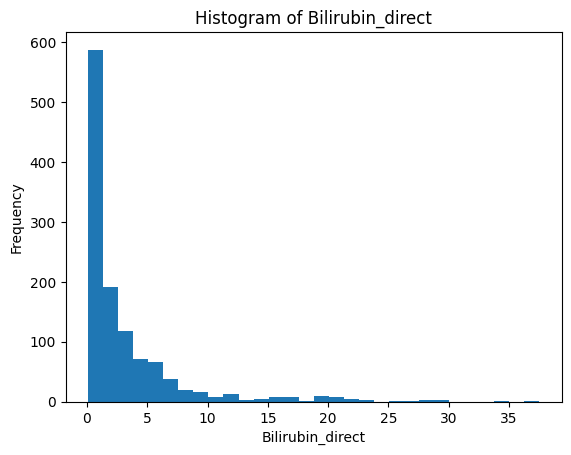

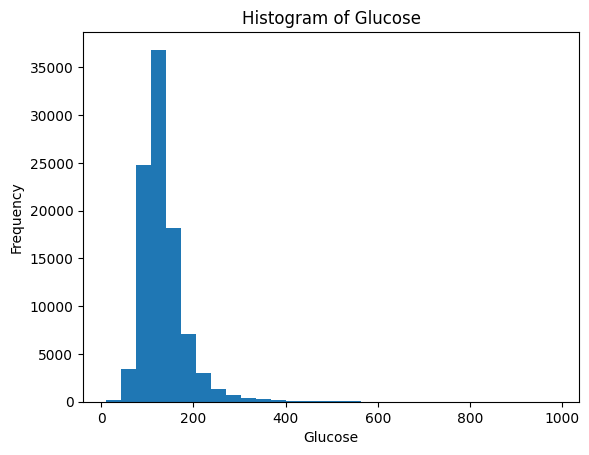

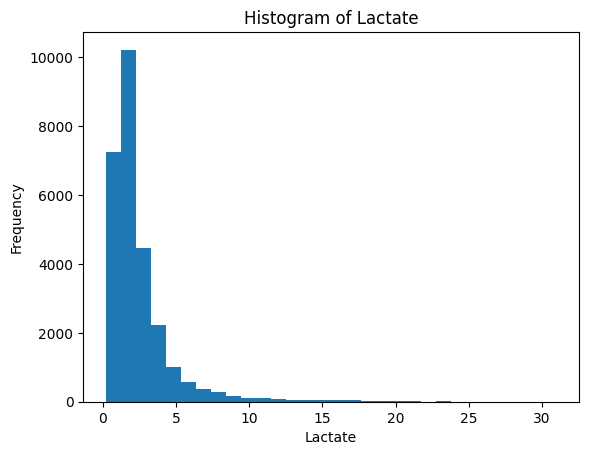

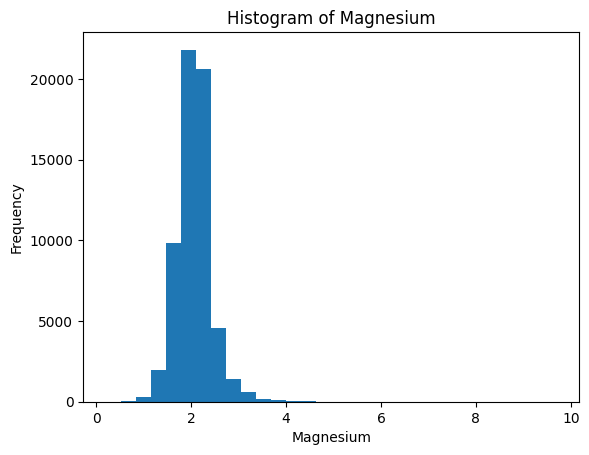

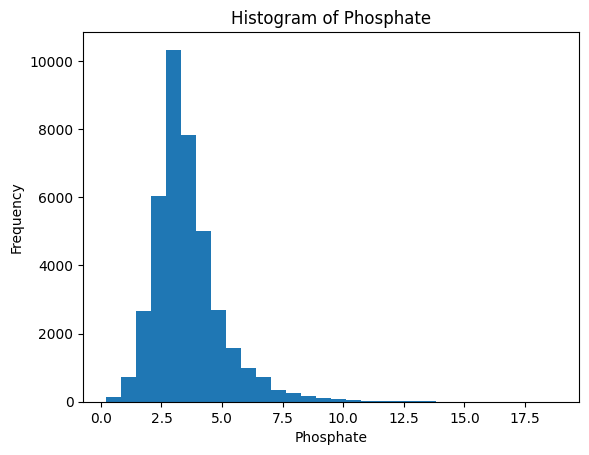

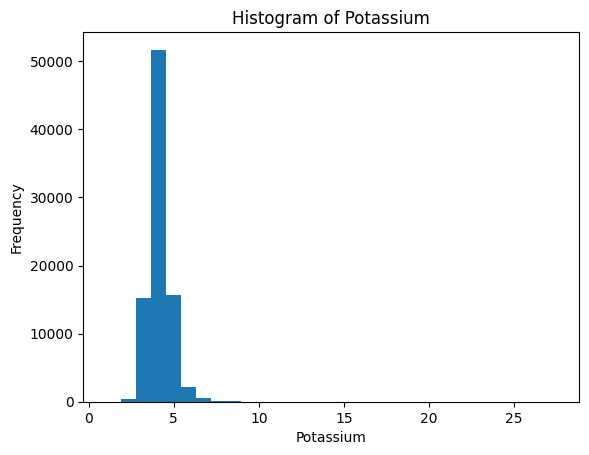

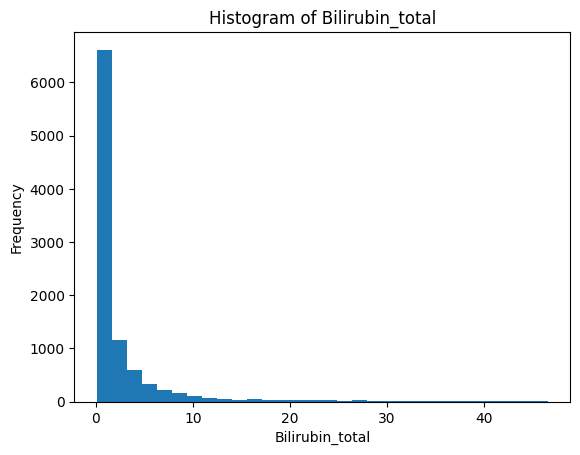

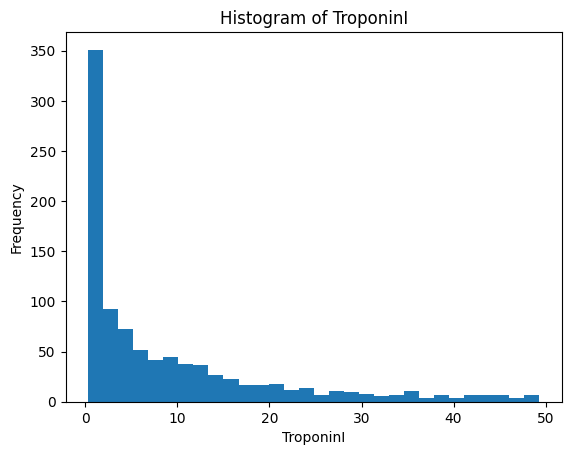

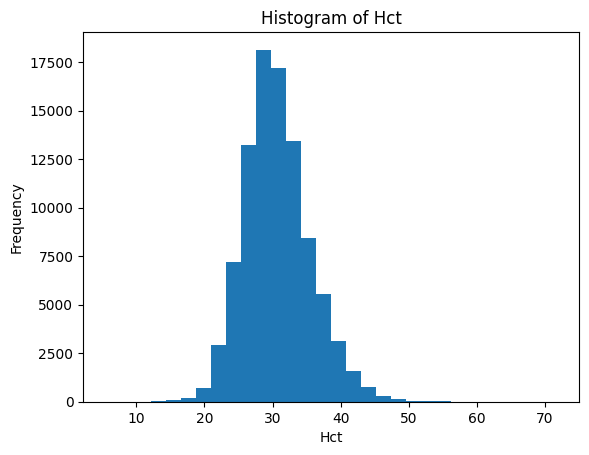

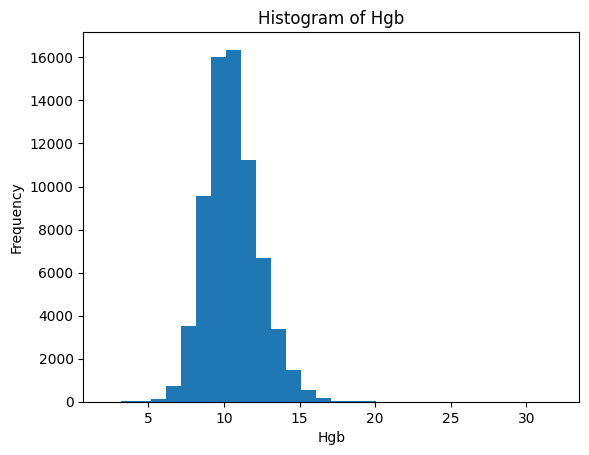

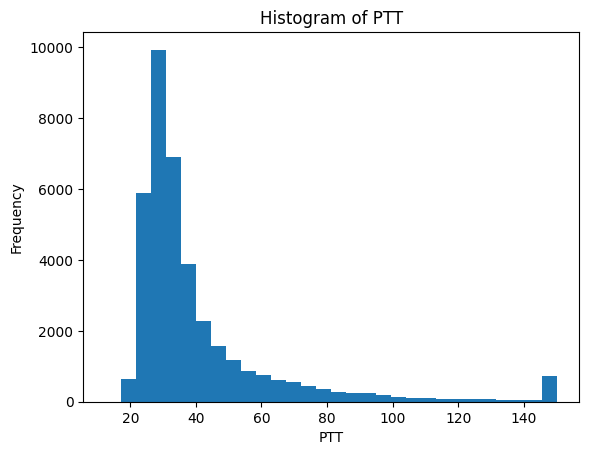

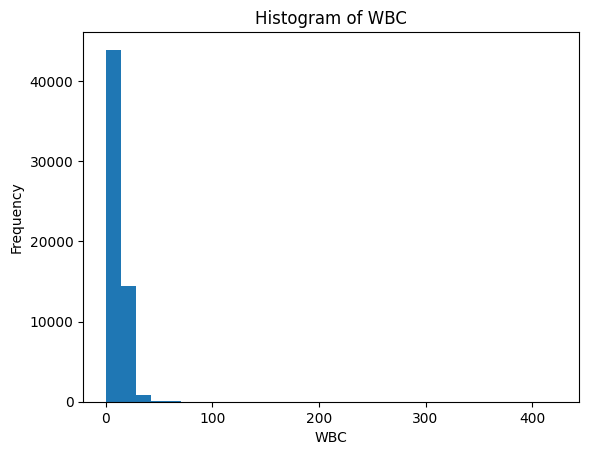

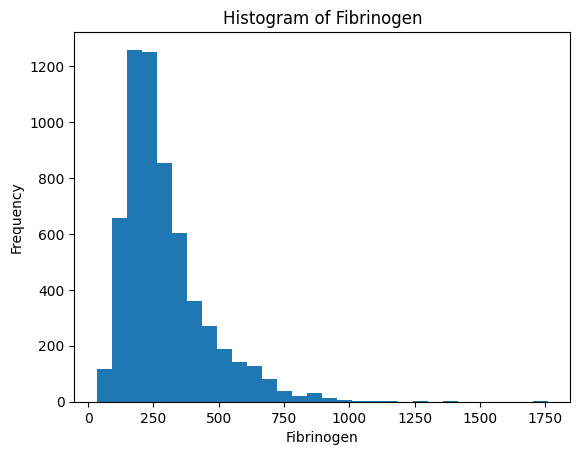

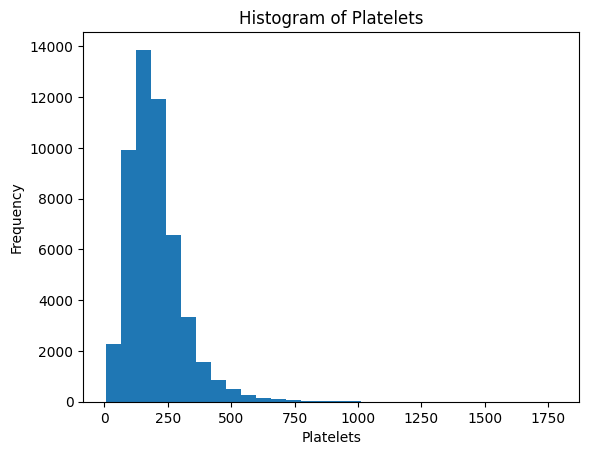

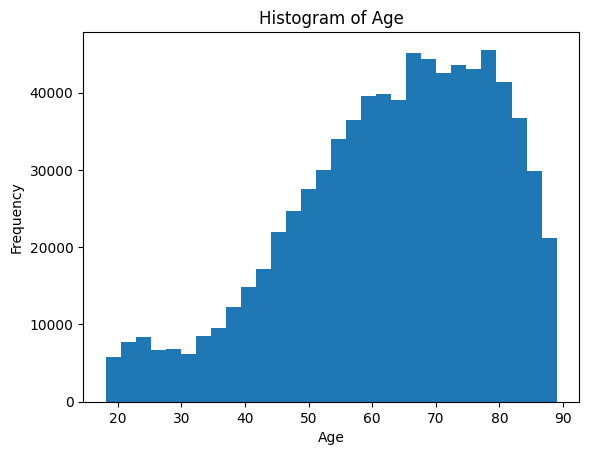

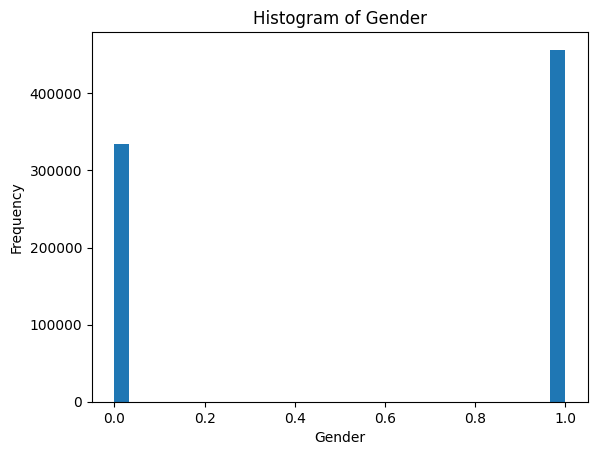

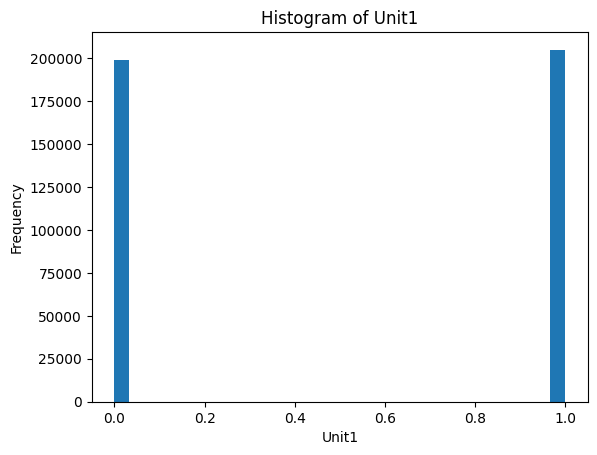

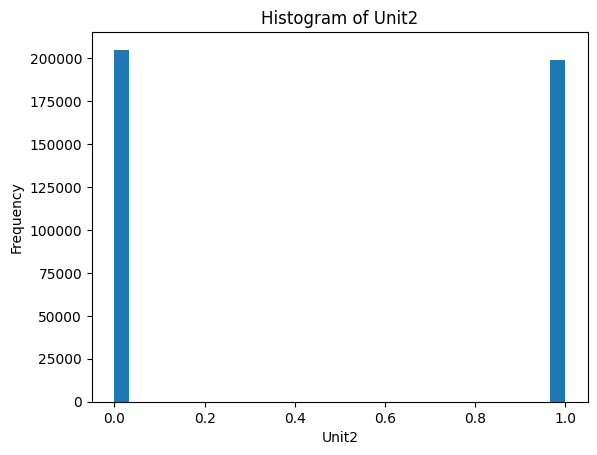

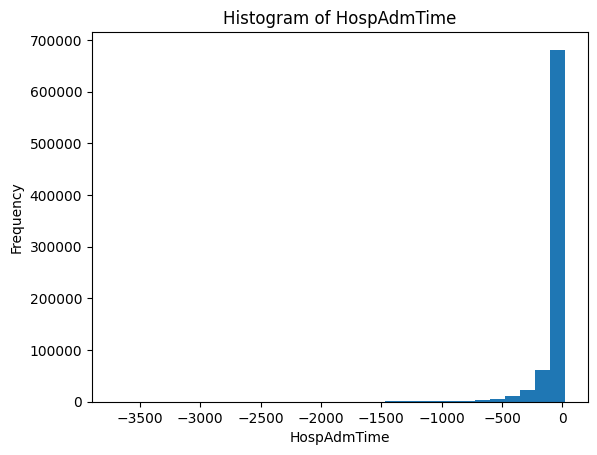

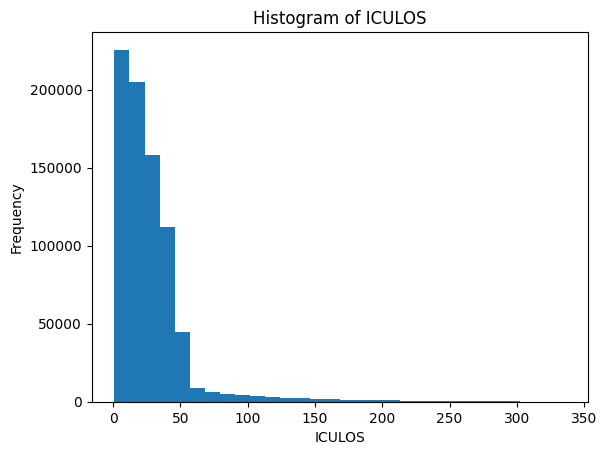

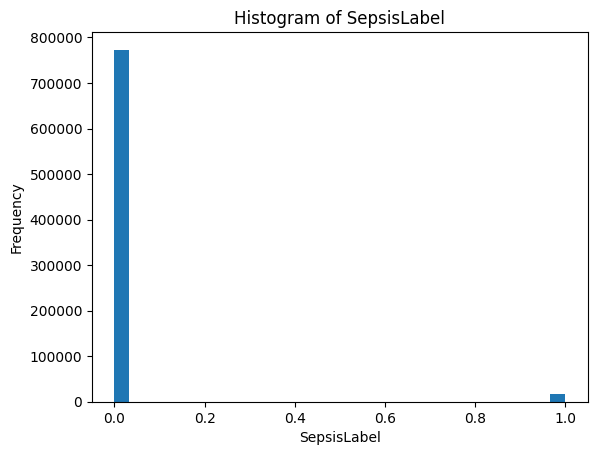

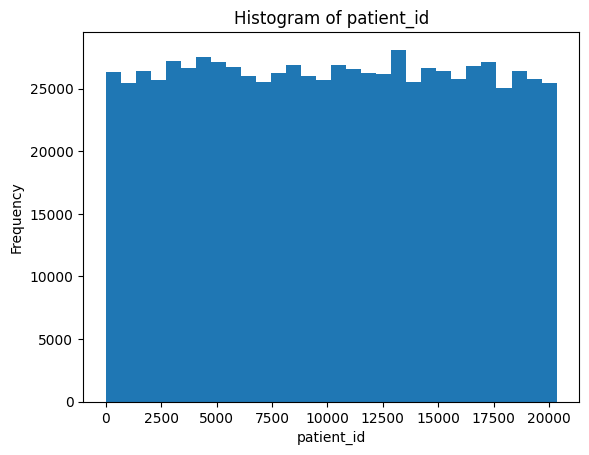

In [49]:
for column in full_df.columns:
    # Generate histogram for the current column
    plt.figure()  # Create a new figure for each column
    full_df[column].plot(kind='hist', bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()  # Display the histogram

In [ ]:
#sns.pairplot(full_df)

### Interpolate

In [ ]:
# interpolate full df
interpolation_limits = [1, 3, 5]

full_df_interpolated = [pd.concat([d.interpolate(limit=lim) for d in full_df_from_disk]) for lim in interpolation_limits]

In [ ]:
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit1               0.511317
Unit2               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

We see that the columns `Age, ICULOS, HospAdmTime, Gender` and `SepsisLabel` are thankfully complete. No need to interpolate those, dropping those for further analysis. `EtCO2` is dropped for missing data entirely. One can also discuss dropping measurements with less than 5% overall data at this point.

TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit2               0.511317
Unit1               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp                0.902232
HR            

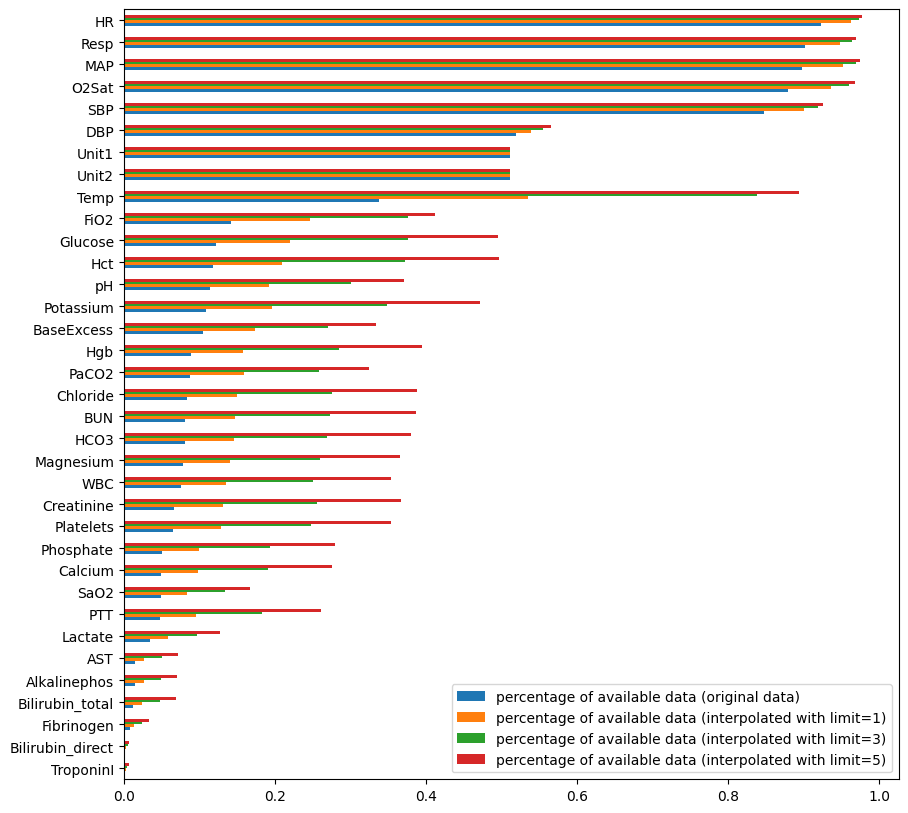

In [ ]:
dropped_cols = ["Age", "ICULOS", "HospAdmTime", "Gender", "SepsisLabel", "EtCO2"]

full_df = full_df.drop(columns=dropped_cols)
full_df_interpolated = [d.drop(columns=dropped_cols) for d in full_df_interpolated]

# recalculate with the smaller data frame.
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

fig, ax = plt.subplots()

value_availability_interpolated = [
    d.count().sort_values()/full_df.shape[0] for d in full_df_interpolated
]

res = pd.concat([value_availability, *value_availability_interpolated],axis=1)

res.plot.barh(figsize=(10,10), ax=ax)
ax.legend(["percentage of available data (original data)", 
           *[f"percentage of available data (interpolated with limit={lim})" for lim in interpolation_limits]])

## Open Questions



*   How to interpolate missing data?
*   How to deal with overly incomplete data/which cases should be excluded?
*   Which models are best suited? LSTM, random forest, ...
*   How to deal with unbalanced data?


